#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다.
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다.
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 :
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 :
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [2]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,8))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KT AIVLE/5차 미프/실습파일/데이터/test.csv')

# data에서 변수 subject는 삭제
# timestamp 열을 datetime 형식으로 변환
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

# 'hour', 'minute', 'second' 열을 추가
train['hour'] = train['timestamp'].dt.hour
train['minute'] = train['timestamp'].dt.minute
train['second'] = train['timestamp'].dt.second

test['timestamp'] = pd.to_datetime(test['timestamp'])

# 'hour', 'minute', 'second' 열을 추가
test['hour'] = test['timestamp'].dt.hour
test['minute'] = test['timestamp'].dt.minute
test['second'] = test['timestamp'].dt.second

train.drop(columns = ['Unnamed: 0', 'timestamp'], inplace=True)
test.drop(columns = ['Unnamed: 0', 'timestamp'], inplace=True)

## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [6]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [7]:
# shape
print(train.shape)
print('='*100)
print(test.shape)

(53219, 10)
(13234, 9)


In [8]:
# info
print(train.info())
print('='*100)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53219 entries, 1 to 99999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A_x     53219 non-null  float64
 1   A_y     53219 non-null  float64
 2   A_z     53219 non-null  float64
 3   B_x     53219 non-null  float64
 4   B_y     53219 non-null  float64
 5   B_z     53219 non-null  float64
 6   label   53219 non-null  int64  
 7   hour    53219 non-null  int64  
 8   minute  53219 non-null  int64  
 9   second  53219 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 4.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13234 entries, 0 to 13233
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A_x     13234 non-null  float64
 1   A_y     13234 non-null  float64
 2   A_z     13234 non-null  float64
 3   B_x     13234 non-null  float64
 4   B_y     13234 non-null  float64
 5   B_z     13234 non-nu

In [9]:
# decribe
print(train.describe())
print('='*100)
print(test.describe())

                A_x           A_y           A_z           B_x           B_y  \
count  53219.000000  53219.000000  53219.000000  53219.000000  53219.000000   
mean      -0.877294     -0.108733     -0.013489     -0.779756      0.115047   
std        0.463339      0.347211      0.361346      0.813368      0.592512   
min       -5.112929     -1.949310     -1.284750     -7.483251     -5.381570   
25%       -1.016930     -0.179784     -0.281388     -1.049334     -0.192097   
50%       -0.958883     -0.047223     -0.063627     -0.918018      0.022717   
75%       -0.766159      0.060663      0.221118     -0.158293      0.317289   
max        1.849398      2.413866      2.457464      5.372528      7.182237   

                B_z         label          hour        minute        second  
count  53219.000000  53219.000000  53219.000000  53219.000000  53219.000000  
mean       0.165634      5.929762      0.415622     30.678104     28.853098  
std        0.786266      3.334749      0.609066     19

In [10]:
display(train.head())
print('='*100)
display(test.head())

,A_x,A_y,A_z,B_x,B_y,B_z,label,hour,minute,second
1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2,1,37,6
2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8,0,45,33
3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11,0,46,22
4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6,0,49,56
5,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,2,1,34,24


,A_x,A_y,A_z,B_x,B_y,B_z,hour,minute,second
0,-1.000957,-0.170691,0.124889,-0.979561,0.003150,-0.264673,0,0,42
1,-0.874830,0.132696,-0.501727,-1.274911,0.045122,0.121270,0,28,38
2,-1.219112,0.074678,0.435331,-0.860820,0.222740,0.008689,0,7,23
3,-0.907752,-0.171816,0.211507,-0.972017,0.337799,1.013534,1,58,44
4,-1.031261,0.000340,-0.091693,-0.217434,-0.323466,0.931614,0,59,32


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

<< 기초통계량 >>


,count,mean,std,min,25%,50%,75%,max
label,53219.0,5.929762,3.334749,1.0,3.0,6.0,9.0,11.0


<< 그래프 >>
<< 범주별 빈도수 >>
2     6453
1     6188
8     6056
7     5670
10    5068
9     4891
11    4838
3     4428
4     3853
5     2913
6     2861
Name: label, dtype: int64
<< 범주별 비율 >>
2     0.121254
1     0.116274
8     0.113794
7     0.106541
10    0.095229
9     0.091903
11    0.090907
3     0.083203
4     0.072399
5     0.054736
6     0.053759
Name: label, dtype: float64


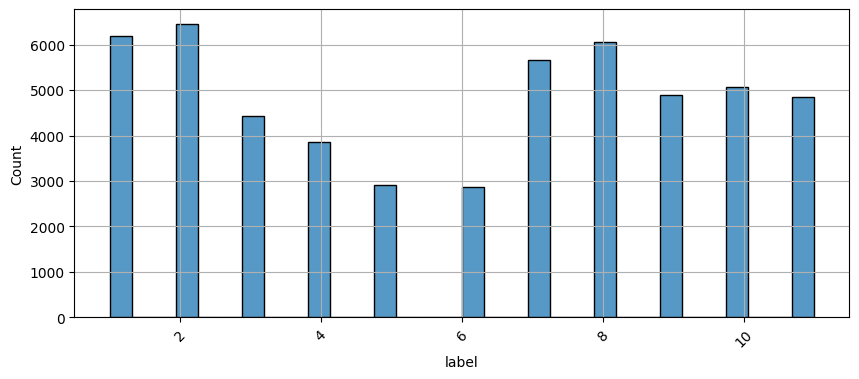

In [11]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'label'
eda_1_num(train, target)

In [12]:
from imblearn.over_sampling import SMOTE

# SMOTE 객체 생성
smote = SMOTE(random_state=42)
y_train = train['label']
X_train = train.drop(columns = 'label')
# X_train, y_train은 훈련 데이터의 특징과 레이블을 나타냅니다.
# 이 두 변수를 사용하여 SMOTE를 적용합니다.
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)  # X_train.columns는 특징 열의 이름들을 나타냅니다
y_resampled_df = pd.Series(y_resampled, name='label')  # 'target'은 새로운 레이블 열의 이름입니다

# X_resampled_df와 y_resampled_df를 합쳐서 resampled_df를 생성
train = pd.concat([X_resampled_df, y_resampled_df], axis=1)
train

,A_x,A_y,A_z,B_x,B_y,B_z,hour,minute,second,label
0,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,1,37,6,2
1,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,0,45,33,8
2,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,0,46,22,11
3,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,0,49,56,6
4,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,1,34,24,2
...,...,...,...,...,...,...,...,...,...,...
70978,-1.109399,-0.095319,0.381631,-0.823535,-0.028876,0.146295,0,17,8,11
70979,-0.959333,-0.067261,0.352323,-1.038467,0.088525,0.026165,0,34,2,11
70980,-0.928065,-0.057637,0.467929,-1.253888,-0.058589,0.094800,0,12,26,11
70981,-0.768061,-0.124282,0.291681,-1.176916,0.035379,0.355506,0,19,54,11


<< 기초통계량 >>


,count,mean,std,min,25%,50%,75%,max
label,70983.0,6.0,3.1623,1.0,3.0,6.0,9.0,11.0


<< 그래프 >>
<< 범주별 빈도수 >>
2     6453
8     6453
11    6453
6     6453
4     6453
5     6453
10    6453
1     6453
3     6453
7     6453
9     6453
Name: label, dtype: int64
<< 범주별 비율 >>
2     0.090909
8     0.090909
11    0.090909
6     0.090909
4     0.090909
5     0.090909
10    0.090909
1     0.090909
3     0.090909
7     0.090909
9     0.090909
Name: label, dtype: float64


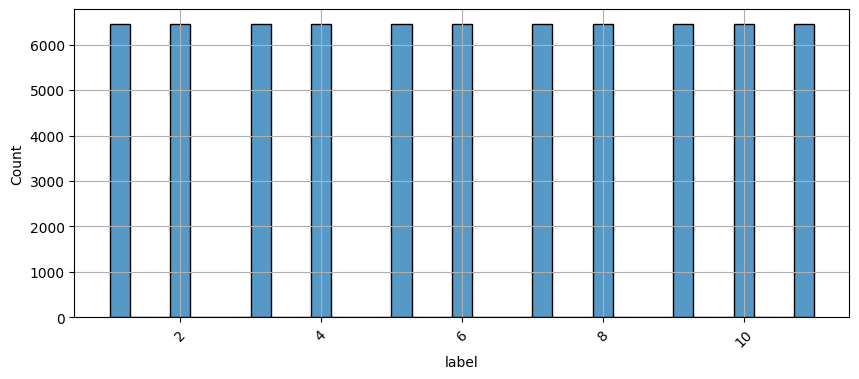

In [13]:
def eda_1_num(data, target):

    # 기초통계량
    print('<< 기초통계량 >>')
    display(data[[target]].describe().T)
    print('=' * 100)

    # 시각화
    print('<< 그래프 >>')
    plt.figure(figsize=(10, 4))
    sns.histplot(data[target])
    plt.grid()
    plt.xticks(rotation=45)

    category_counts = data[target].value_counts()
    category_proportions = data[target].value_counts(normalize=True)

    print('<< 범주별 빈도수 >>')
    print(category_counts)
    print('=' * 100)

    print('<< 범주별 비율 >>')
    print(category_proportions)
    print('=' * 100)

target = 'label'
eda_1_num(train, target)

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다.
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [14]:
# x, y로 나누기
y = train['label']
x = train.drop(columns = 'label')

In [20]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
test = scaler.transform(test)

In [ ]:
# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, stratify = y, random_state=42, test_size=0.2)

In [ ]:
models = [
    # ('ada', AdaBoostClassifier()),
    # ('bc', BaggingClassifier()),
    # ('etc',ExtraTreesClassifier()),
    # ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    ('knn', KNeighborsClassifier()),
    # ('svc', SVC(probability=True)),
    # ('xgb', XGBClassifier()),
    # ('dtc', DecisionTreeClassifier()),
    ('lr', LogisticRegression(max_iter=100000)),
    # ('ridge', RidgeClassifier()),
]

final_estimator = RandomForestClassifier()

# StackingClassifier로 생성한 모델
stacking_clf = StackingClassifier(estimators=models, final_estimator=final_estimator)

# StackingClassifier 모델 학습
stacking_clf.fit(X_train, y_train)

# 최종 예측
final_predictions = stacking_clf.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score

final_accuracy = accuracy_score(y_val, final_predictions)
final_macro_f1 = f1_score(y_val, final_predictions, average='macro')

print(f"Final voting_soft Accuracy={final_accuracy:.4f}, Final voting_soft Macro F1 Score={final_macro_f1:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Final voting_soft Accuracy=0.9942, Final voting_soft Macro F1 Score=0.9942


# 제출할만하면 여기서 돌리고 저장

In [26]:
models = [
    ('ridge', RidgeClassifier()),
    # ('ada', AdaBoostClassifier()),
    # ('bc', BaggingClassifier()),
    # ('etc',ExtraTreesClassifier()),
    # ('gbc', GradientBoostingClassifier()),
    ('rfc', RandomForestClassifier()),
    ('knn', KNeighborsClassifier()),
    # ('svc', SVC(probability=True)),
    # ('xgb', XGBClassifier()),
    # ('dtc', DecisionTreeClassifier()),
    ('lr', LogisticRegression(max_iter=100000)),
]

final_estimator = RandomForestClassifier()

# StackingClassifier로 생성한 모델
stacking_clf = StackingClassifier(estimators=models, final_estimator=final_estimator)

# StackingClassifier 모델 학습
stacking_clf.fit(x, y)

StackingClassifier(estimators=[('ridge', RidgeClassifier()),
                               ('rfc', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier()),
                               ('lr', LogisticRegression(max_iter=100000))],
                   final_estimator=RandomForestClassifier())

In [27]:
y_pred = stacking_clf.predict(test)

# 예측 결과를 DataFrame으로 만들기
result_df = pd.DataFrame({'label': y_pred})

# CSV 파일로 저장
result_df.to_csv('prediction_results_stack_scale4.csv', index_label='ID')

pd.read_csv('prediction_results_stack_scale4.csv')

,ID,label
0,0,6
1,1,4
2,2,10
3,3,9
4,4,7
...,...,...
13229,13229,3
13230,13230,9
13231,13231,4
13232,13232,1


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

,feature_name,feature_importance
0,A_z,0.232642
1,B_x,0.180181
2,B_z,0.174060
3,A_x,0.160634
4,A_y,0.137671
5,B_y,0.114812


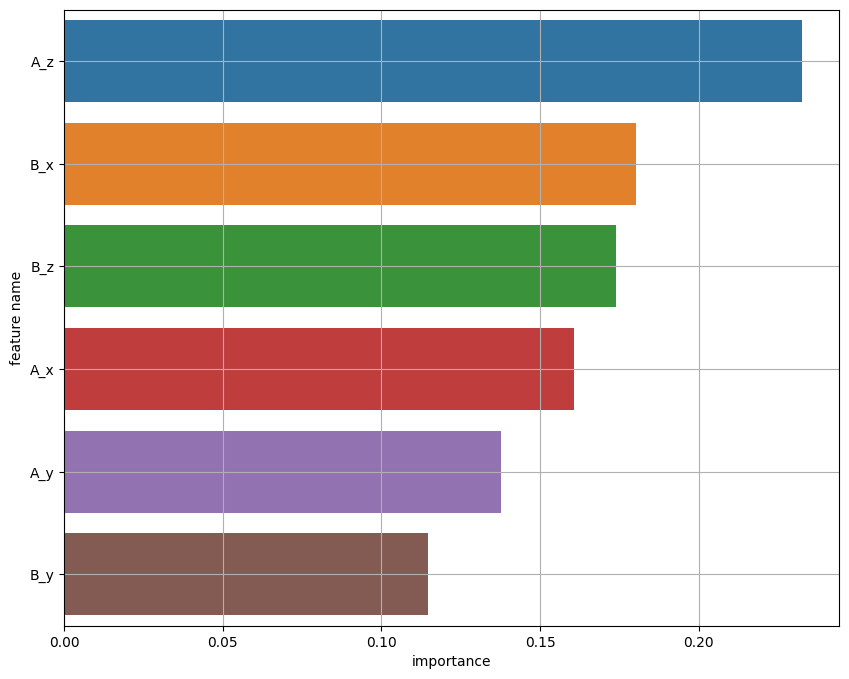

In [ ]:
plot_feature_importances = model_RF.feature_importances_
plot_feature_importance(plot_feature_importances, X_train.columns, result_only=False, topn=10)

In [ ]:
Feature_names = X_train.columns

In [ ]:
# 상위 10개
top10_importances = []
print("상위 10개 변수:")
for idx in indices[:]:
    top10_importances.append(Feature_names[idx])
top10_importances

상위 10개 변수:


['A_z', 'B_x', 'B_z', 'A_x', 'A_y', 'B_y']

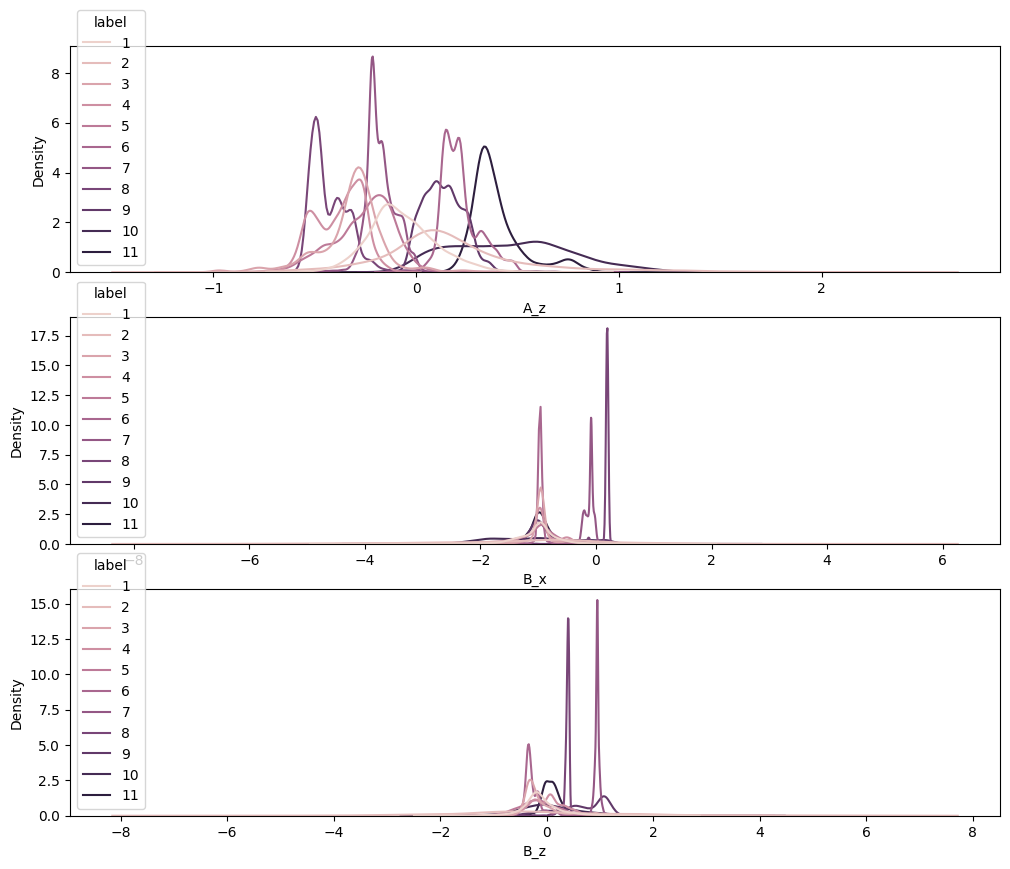

In [ ]:
plt.figure(figsize=(12, 10))
plt.subplot(3,1,1)
sns.kdeplot(data=X_train, x=top10_importances[0], hue=y_train, common_norm=False)

plt.subplot(3,1,2)
sns.kdeplot(data=X_train, x=top10_importances[1], hue=y_train, common_norm=False)

plt.subplot(3,1,3)
sns.kdeplot(data=X_train, x=top10_importances[2], hue=y_train, common_norm=False)

plt.show()
